In [ ]:
from google.colab import files

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgb

from xgboost import XGBClassifier, XGBRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import ensemble
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier as GBoost, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import seaborn as sns

%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/SHIFT/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/SHIFT/y_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/SHIFT/X_test.csv')

In [ ]:
train_data = X_train.merge(y_train)
train_data

,index,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,...,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code,loan_status
0,0,0.0,UT,80000.0,0.0,0.0,0.0,30.49,Oct-1996,4 years,...,1.0,credit_card,56.1%,0.0,36 months,Credit card refinancing,26.0,Source Verified,847xx,1
1,1,0.0,CA,82000.0,0.0,0.0,0.0,7.00,Mar-1993,10+ years,...,1.0,credit_card,88.3%,0.0,36 months,Credit card refinancing,11.0,Not Verified,900xx,0
2,2,0.0,NV,46080.0,0.0,0.0,1.0,17.32,Nov-2000,3 years,...,0.0,credit_card,18.1%,0.0,36 months,Credit card refinancing,31.0,Source Verified,895xx,1
3,3,0.0,AZ,30000.0,0.0,0.0,0.0,7.80,Jan-2010,< 1 year,...,0.0,car,33.4%,0.0,36 months,Car financing,24.0,Source Verified,853xx,0
4,4,0.0,OH,70000.0,0.0,0.0,0.0,13.36,Jan-2002,< 1 year,...,0.0,other,88.6%,0.0,60 months,Other,16.0,Not Verified,453xx,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199856,1199856,0.0,IL,41000.0,0.0,0.0,0.0,22.97,Feb-2002,4 years,...,0.0,debt_consolidation,82.1%,0.0,36 months,debt consolidation,8.0,Source Verified,604xx,0
1199857,1199857,0.0,NY,95000.0,0.0,0.0,0.0,25.63,Jan-2002,3 years,...,0.0,credit_card,82.3%,0.0,36 months,Credit cards financing,29.0,Verified,106xx,0
1199858,1199858,0.0,MA,61000.0,0.0,0.0,0.0,15.58,Nov-2002,8 years,...,0.0,home_improvement,6%,0.0,60 months,Home improvement,26.0,Source Verified,021xx,0
1199859,1199859,0.0,OH,35000.0,0.0,0.0,0.0,24.07,Nov-1991,5 years,...,0.0,debt_consolidation,76.2%,0.0,60 months,Debt,52.0,Verified,454xx,0


In [ ]:
# подсчет количества займов на 3 года и на 5 лет
count_3_years = len(X_test[X_test['term'] == ' 36 months'])
count_5_years = len(X_test[X_test['term'] == ' 60 months'])

# вывод результата
print("Количество займов на 3 года:", count_3_years)
print("Количество займов на 5 лет:", count_5_years)

Количество займов на 3 года: 0
Количество займов на 5 лет: 0


In [ ]:
train_data['earliest_cr_line'] = train_data['earliest_cr_line'].dt.year
train_data.earliest_cr_line.unique()

In [ ]:
# нахождение порога для 10% самых богатых
top_10_percent_income = train_data['annual_inc'].quantile(0.9)

# выбор только тех строк, где доход выше порога для 10% самых богатых
top_10_percent_df = train_data[train_data['annual_inc'] >= top_10_percent_income]

# подсчет доли дефолтов для 10% самых богатых
default_rate_top_10_percent = top_10_percent_df['loan_status'].mean()

# выбор только тех строк, где доход ниже порога для 10% самых богатых
rest_df = train_data[train_data['annual_inc'] < top_10_percent_income]

# подсчет доли дефолтов для остальных заемщиков
default_rate_rest = rest_df['loan_status'].mean()

# вывод результата
print("Доля дефолтов для 10% самых богатых:", default_rate_top_10_percent)
print("Доля дефолтов для остальных заемщиков:", default_rate_rest)

Доля дефолтов для 10% самых богатых: 0.15169243627246135
Доля дефолтов для остальных заемщиков: 0.1977096318673468


In [ ]:
train_data.acc_now_delinq.unique()

array([0., 1., 2., 3., 5., 4., 6.])

In [ ]:
train_data = train_data.drop(labels='index', axis=1)
X_test = X_test.drop(labels='index', axis=1)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199861 entries, 0 to 1199860
Data columns (total 46 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   index                       1199861 non-null  int64  
 1   acc_now_delinq              1199861 non-null  float64
 2   addr_state                  1199861 non-null  object 
 3   annual_inc                  1199861 non-null  float64
 4   chargeoff_within_12_mths    1199824 non-null  float64
 5   collections_12_mths_ex_med  1199824 non-null  float64
 6   delinq_2yrs                 1199861 non-null  float64
 7   dti                         1199861 non-null  float64
 8   earliest_cr_line            1199861 non-null  object 
 9   emp_length                  1128114 non-null  object 
 10  fico_range_high             1199861 non-null  float64
 11  fico_range_low              1199861 non-null  float64
 12  funded_amnt                 1199861 non-null  float64
 1

In [ ]:
train_data.isna().sum()

acc_now_delinq                     0
addr_state                         0
annual_inc                         0
chargeoff_within_12_mths          37
collections_12_mths_ex_med        37
delinq_2yrs                        0
dti                                0
earliest_cr_line                   0
emp_length                     71747
fico_range_high                    0
fico_range_low                     0
funded_amnt                        0
home_ownership                     0
inq_last_12m                  567215
installment                        0
int_rate                           0
issue_d                            0
loan_amnt                          0
mort_acc                       31541
mths_since_last_delinq        607443
mths_since_recent_bc_dlq      917196
mths_since_recent_inq         149781
num_accts_ever_120_pd          45009
num_actv_bc_tl                 45009
num_rev_accts                  45010
num_sats                       37295
num_tl_120dpd_2m               90608
n

In [ ]:
train_data.nunique()

acc_now_delinq                    7
addr_state                       51
annual_inc                    59051
chargeoff_within_12_mths         11
collections_12_mths_ex_med       13
delinq_2yrs                      32
dti                            4747
earliest_cr_line                748
emp_length                       11
fico_range_high                  38
fico_range_low                   38
funded_amnt                    1562
home_ownership                    6
inq_last_12m                     45
installment                   81217
int_rate                        669
issue_d                         160
loan_amnt                      1562
mort_acc                         39
mths_since_last_delinq          167
mths_since_recent_bc_dlq        168
mths_since_recent_inq            26
num_accts_ever_120_pd            43
num_actv_bc_tl                   36
num_rev_accts                   111
num_sats                         83
num_tl_120dpd_2m                  6
num_tl_30dpd                

In [ ]:
train_data.describe()

,acc_now_delinq,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,fico_range_high,fico_range_low,funded_amnt,inq_last_12m,...,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,tax_liens,total_acc,loan_status
count,1.199861e+06,1.199861e+06,1.199824e+06,1.199824e+06,1.199861e+06,1.199861e+06,1.199861e+06,1.199861e+06,1.199861e+06,632646.000000,...,1.154852e+06,1.199861e+06,632647.000000,632647.000000,1.155527e+06,1.199861e+06,1.199394e+06,1.199833e+06,1.199861e+06,1.199861e+06
mean,4.625536e-03,7.811051e+04,8.901306e-03,1.810182e-02,3.142264e-01,1.803875e+01,7.012003e+02,6.972001e+02,1.440466e+04,2.180682,...,2.156888e+00,1.162006e+01,1.677463,2.899328,4.318438e+01,2.097351e-01,1.326236e-01,5.066205e-02,2.464238e+01,1.930290e-01
std,7.284156e-02,1.363514e+05,1.081550e-01,1.507312e-01,8.763691e-01,8.404678e+00,3.234104e+01,3.234036e+01,8.855223e+03,2.458328,...,1.853938e+00,5.574730e+00,1.641795,2.667496,3.613864e+01,5.909437e-01,3.732363e-01,3.914037e-01,1.205229e+01,3.946758e-01
min,0.000000e+00,2.300000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,6.640000e+02,6.600000e+02,5.000000e+02,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00
25%,0.000000e+00,4.700000e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.174000e+01,6.740000e+02,6.700000e+02,7.675000e+03,0.000000,...,1.000000e+00,8.000000e+00,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,0.000000e+00
50%,0.000000e+00,6.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.755000e+01,6.940000e+02,6.900000e+02,1.200000e+04,2.000000,...,2.000000e+00,1.100000e+01,1.000000,2.000000,4.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,0.000000e+00
75%,0.000000e+00,9.300000e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.397000e+01,7.190000e+02,7.150000e+02,2.000000e+04,3.000000,...,3.000000e+00,1.400000e+01,2.000000,4.000000,7.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,0.000000e+00
max,6.000000e+00,1.100000e+08,1.000000e+01,2.000000e+01,4.200000e+01,4.996000e+01,8.500000e+02,8.450000e+02,4.000000e+04,49.000000,...,3.200000e+01,9.000000e+01,39.000000,54.000000,1.000000e+02,8.600000e+01,1.200000e+01,8.500000e+01,1.730000e+02,1.000000e+00


In [ ]:
columns_to_convert = ['int_rate', 'revol_util']

for col in columns_to_convert:
    train_data[col] = train_data[col].str.replace('%', '').astype(float)
    X_test[col] = X_test[col].str.replace('%', '').astype(float)

In [ ]:
columns_to_convert = ['issue_d', 'earliest_cr_line']

for col in columns_to_convert:
    train_data[col] = pd.to_datetime(train_data[col], format='%b-%Y')
    train_data[f'month_{col}'] = train_data[col].dt.month
    X_test[col] = pd.to_datetime(X_test[col], format='%b-%Y')
    X_test[f'month_{col}'] = X_test[col].dt.month

In [ ]:
train_data = train_data.drop(columns=['issue_d', 'earliest_cr_line'])
X_test = X_test.drop(columns=['issue_d', 'earliest_cr_line'])

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199861 entries, 0 to 1199860
Data columns (total 46 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   index                       1199861 non-null  int64  
 1   acc_now_delinq              1199861 non-null  float64
 2   addr_state                  1199861 non-null  object 
 3   annual_inc                  1199861 non-null  float64
 4   chargeoff_within_12_mths    1199824 non-null  float64
 5   collections_12_mths_ex_med  1199824 non-null  float64
 6   delinq_2yrs                 1199861 non-null  float64
 7   dti                         1199861 non-null  float64
 8   emp_length                  1128114 non-null  object 
 9   fico_range_high             1199861 non-null  float64
 10  fico_range_low              1199861 non-null  float64
 11  funded_amnt                 1199861 non-null  float64
 12  home_ownership              1199861 non-null  object 
 1

<ipython-input-13-a21602080c8f>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<Axes: >

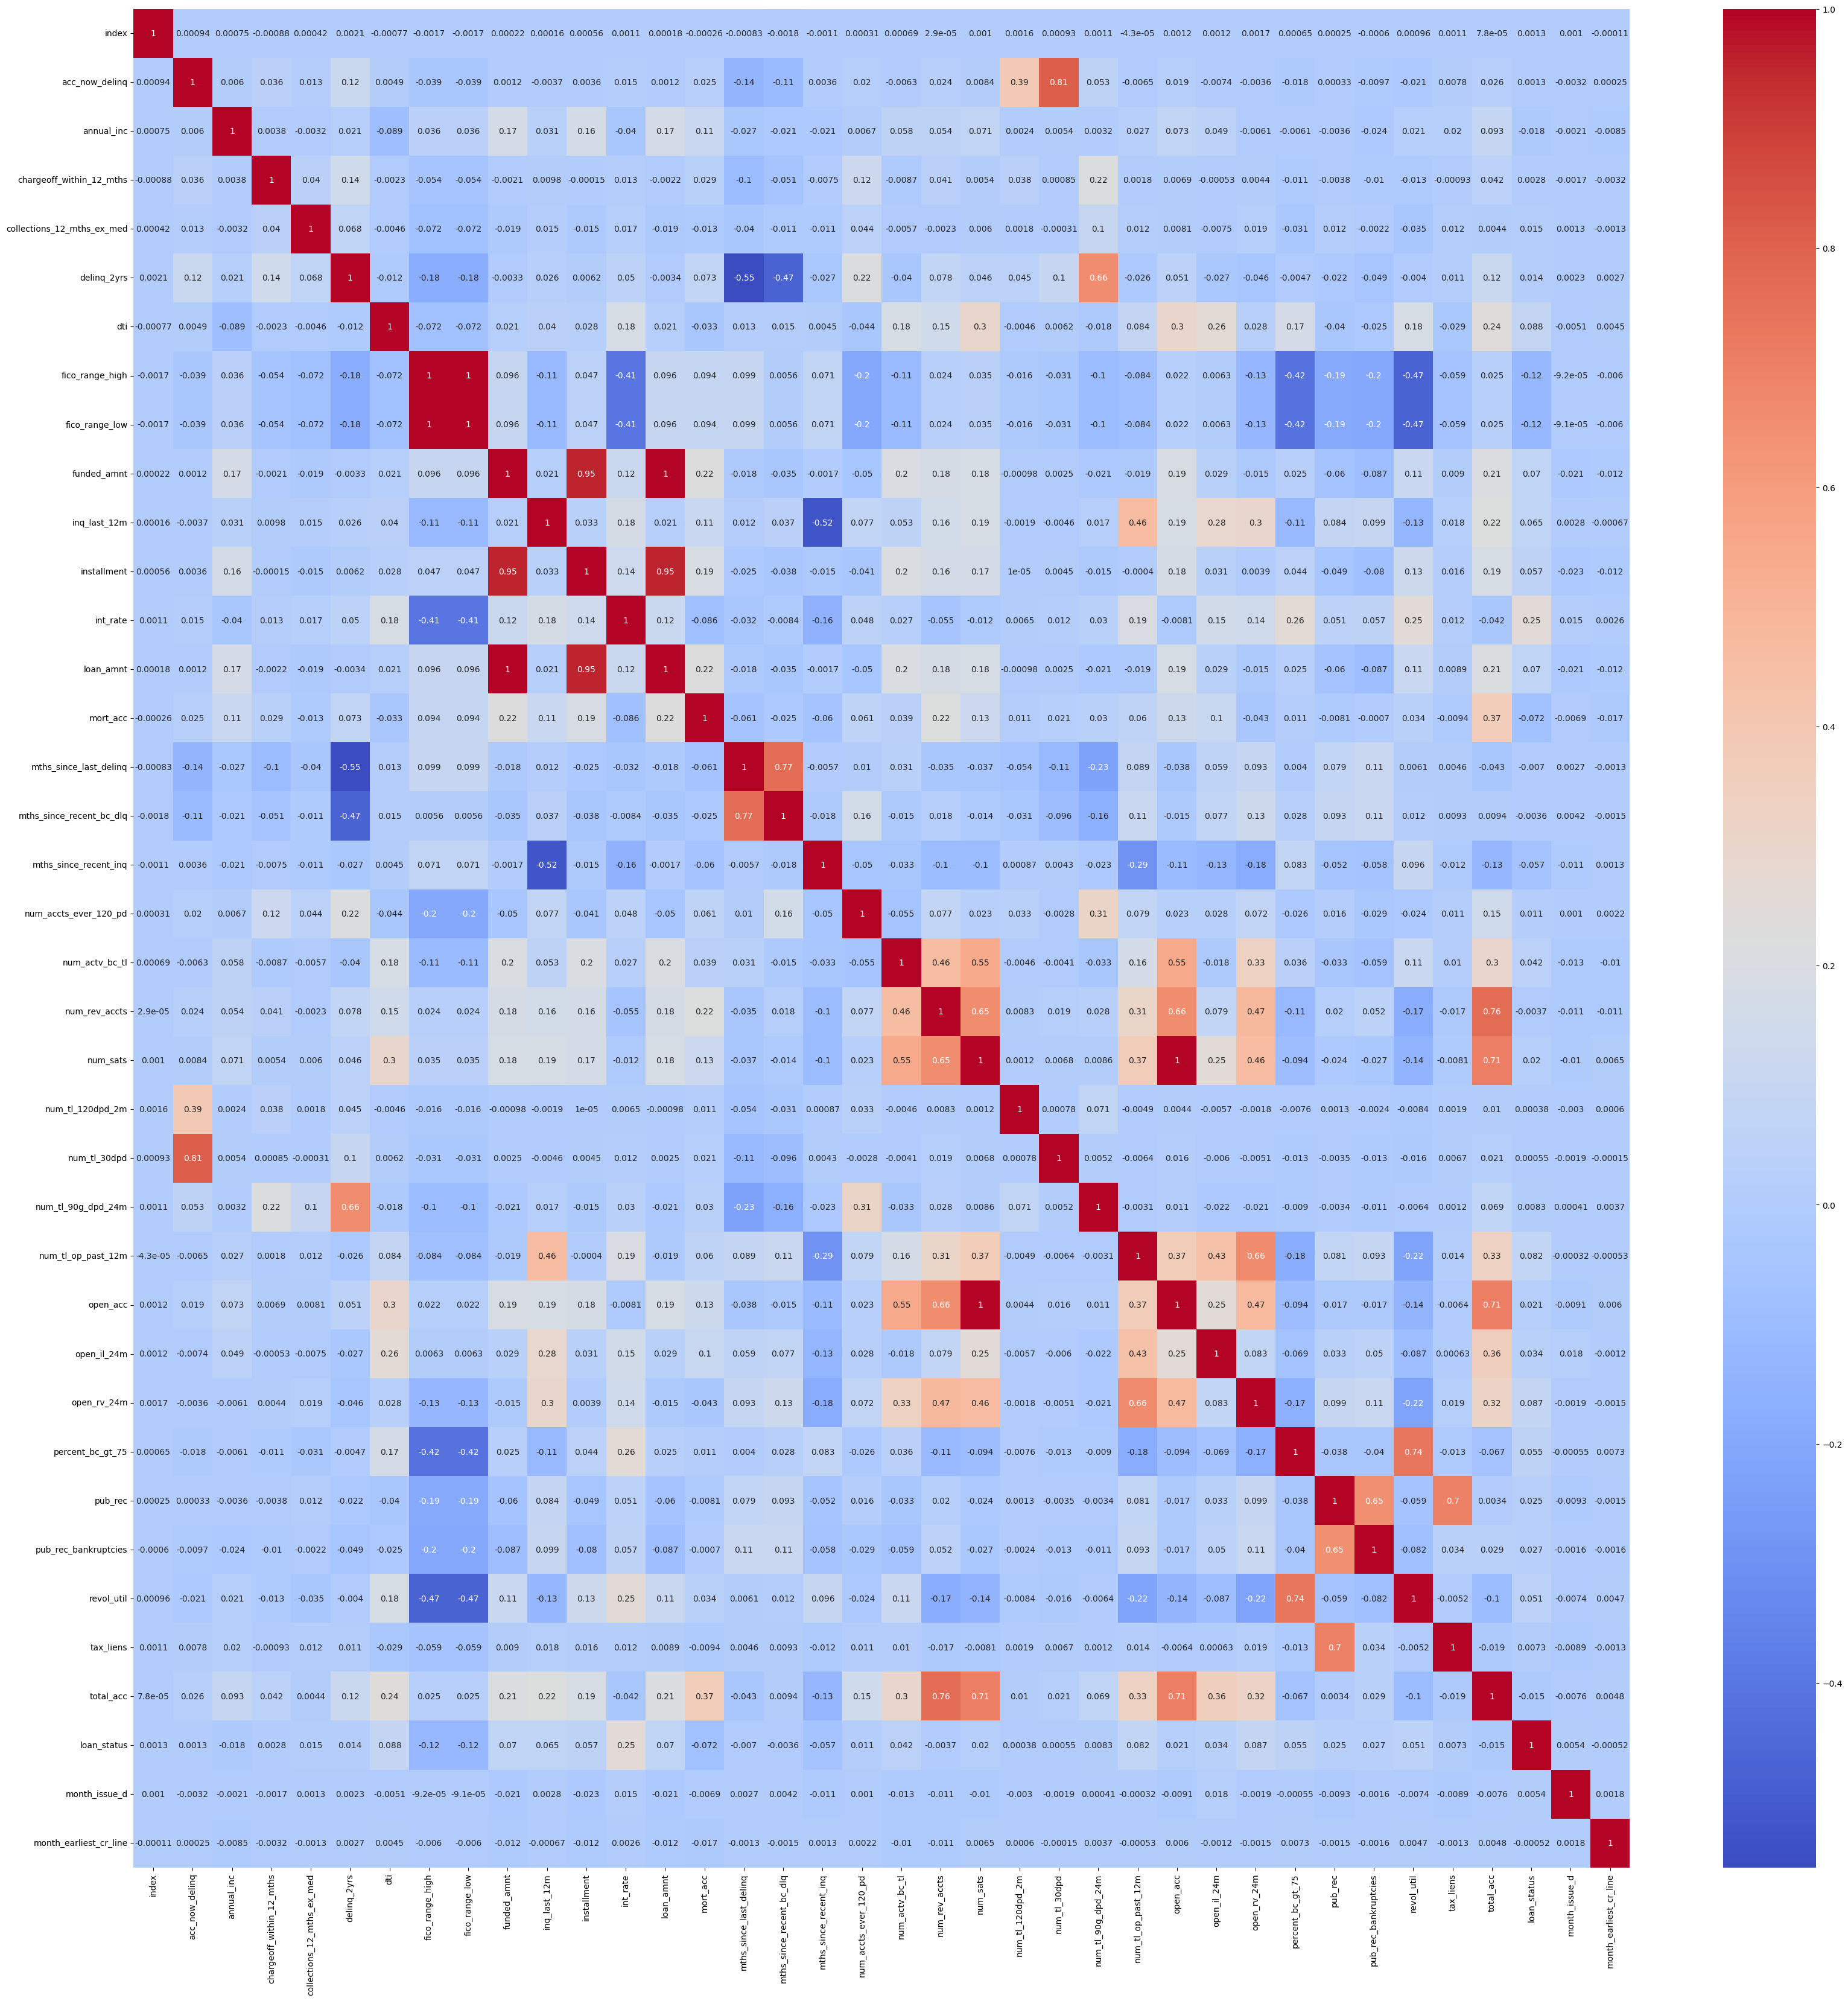

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cols = train_data.columns

df = train_data[cols]
corr_matrix = df.corr()
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [ ]:
for i in train_data.iloc[:, 1:].columns:
  if train_data[i].notna().sum() < 0.8 * len(train_data):
    del train_data[i]

for i in X_test.iloc[:, 1:].columns:
  if X_test[i].notna().sum() < 0.8 * len(X_test):
    del X_test[i]

In [ ]:
train_data.shape

(1199861, 41)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199861 entries, 0 to 1199860
Data columns (total 41 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   index                       1199861 non-null  int64  
 1   acc_now_delinq              1199861 non-null  float64
 2   addr_state                  1199861 non-null  object 
 3   annual_inc                  1199861 non-null  float64
 4   chargeoff_within_12_mths    1199824 non-null  float64
 5   collections_12_mths_ex_med  1199824 non-null  float64
 6   delinq_2yrs                 1199861 non-null  float64
 7   dti                         1199861 non-null  float64
 8   emp_length                  1128114 non-null  object 
 9   fico_range_high             1199861 non-null  float64
 10  fico_range_low              1199861 non-null  float64
 11  funded_amnt                 1199861 non-null  float64
 12  home_ownership              1199861 non-null  object 
 1

In [ ]:
train_data[['acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']] = train_data[['acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']].astype('object')
X_test[['acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']] = X_test[['acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']].astype('object')

In [ ]:
col_mode = train_data[['emp_length', 'title', 'zip_code','acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']]

ed_mode = train_data[['emp_length', 'title', 'zip_code','acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']].mode().iloc[0]

train_data[['emp_length', 'title', 'zip_code','acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']] = train_data[['emp_length', 'title', 'zip_code','acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']].fillna(ed_mode)


col_mode = X_test[['emp_length', 'title', 'zip_code','acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']]

ed_mode = X_test[['emp_length', 'title', 'zip_code','acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']].mode().iloc[0]

X_test[['emp_length', 'title', 'zip_code','acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']] = X_test[['emp_length', 'title', 'zip_code','acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']].fillna(ed_mode)

In [ ]:
train_data.isna().sum()

acc_now_delinq                     0
addr_state                         0
annual_inc                         0
chargeoff_within_12_mths          37
collections_12_mths_ex_med        37
delinq_2yrs                        0
dti                                0
emp_length                         0
fico_range_high                    0
fico_range_low                     0
funded_amnt                        0
home_ownership                     0
inq_last_12m                  567215
installment                        0
int_rate                           0
loan_amnt                          0
mort_acc                       31541
mths_since_last_delinq        607443
mths_since_recent_inq         149781
num_accts_ever_120_pd          45009
num_actv_bc_tl                 45009
num_rev_accts                  45010
num_sats                       37295
num_tl_120dpd_2m                   0
num_tl_30dpd                       0
num_tl_90g_dpd_24m             45009
num_tl_op_past_12m             45009
o

In [ ]:
median_values = train_data[['mort_acc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_90g_dpd_24m',
                    'num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med','revol_util']].median()
train_data[['mort_acc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_90g_dpd_24m',
            'num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med','revol_util']] = train_data[['mort_acc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_90g_dpd_24m',
                                                                                                                                                                                         'num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med','revol_util']].fillna(median_values)


median_values_test = X_test[['mort_acc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_90g_dpd_24m',
                    'num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med','revol_util']].median()
X_test[['mort_acc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_90g_dpd_24m',
            'num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med','revol_util']] = X_test[['mort_acc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_90g_dpd_24m',
                                                                                                                                                                                         'num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med','revol_util']].fillna(median_values_test)

In [ ]:
train_data.isna().sum()

acc_now_delinq                0
addr_state                    0
annual_inc                    0
chargeoff_within_12_mths      0
collections_12_mths_ex_med    0
delinq_2yrs                   0
dti                           0
emp_length                    0
fico_range_high               0
fico_range_low                0
funded_amnt                   0
home_ownership                0
installment                   0
int_rate                      0
loan_amnt                     0
mort_acc                      0
mths_since_recent_inq         0
num_accts_ever_120_pd         0
num_actv_bc_tl                0
num_rev_accts                 0
num_sats                      0
num_tl_120dpd_2m              0
num_tl_30dpd                  0
num_tl_90g_dpd_24m            0
num_tl_op_past_12m            0
open_acc                      0
percent_bc_gt_75              0
pub_rec                       0
pub_rec_bankruptcies          0
purpose                       0
revol_util                    0
tax_lien

**ГИПОТЕЗЫ**

> 1) Чем меньше годовой доход(annual_inc), тем больше шанс невыплаты долга.

> 2) Коэф. общих ежемесячных выплат заемщика по общим обязательствам по долгам, исключая ипотеку и запрошенную кредит LC, разделенные на самооценку ежемесячного дохода заемщика(dti).

> 3) Количество банкротства публичной записи(pub_rec_bankruptcies) напрямую влияет на невыплату задолженности.

> 4) Чем больше общее количество кредитных линий в настоящее время в кредитном файле заемщика(total_acc) тем больше шанс того, что заёмщик невыплатит долг.

> 5) Чем продолжительность занятости в годы меньше(emp_length), тем больше шанс того, что заёмщик невыплатит долг.

> 6) Чем Процентная ставка по кредиту выше(int_rate), тем больше шанс того, что заёмщик невыплатит долг.

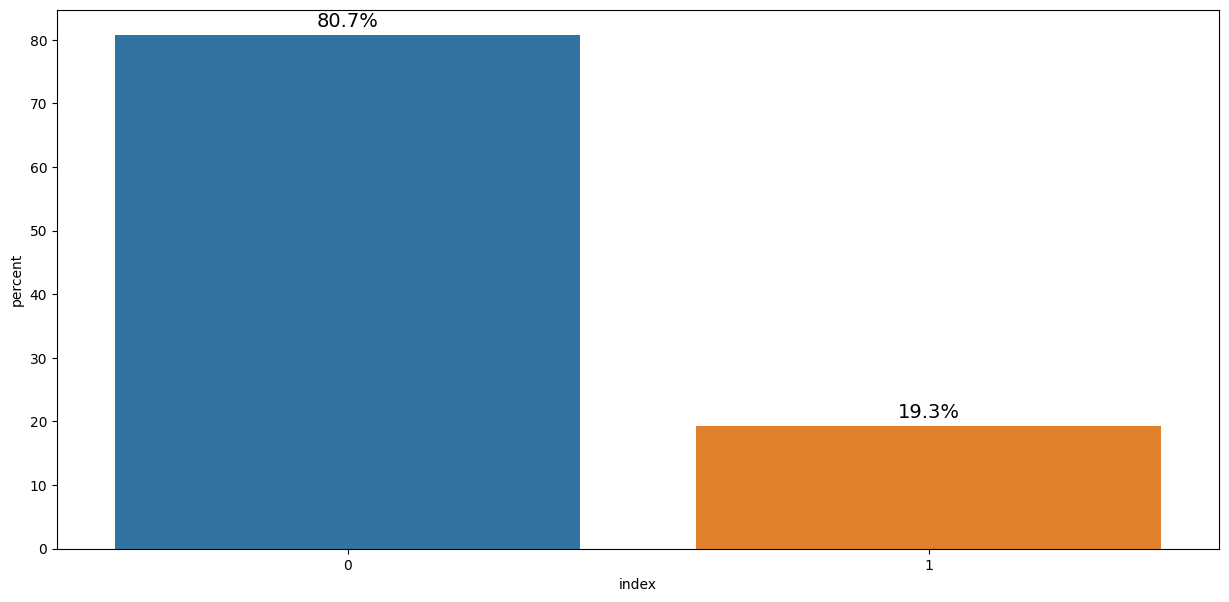

In [ ]:
import matplotlib.pyplot as plt

loan_status_norm = (train_data.loan_status.value_counts(normalize=True).mul(100).rename('percent').reset_index())

plt.figure(figsize=(15,7))
ax = sns.barplot(x='index', y='percent', data=loan_status_norm)

for p in ax.patches:
  percentage = '{:.1f}%'.format(p.get_height())
  ax.annotate(percentage, (p.get_x()+ p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0,10), textcoords='offset points', fontsize=14)

In [ ]:
train_data.groupby('loan_status')['annual_inc'].median()
train_data.groupby('loan_status')['annual_inc'].mean()

loan_status
0    79312.081719
1    73087.269175
Name: annual_inc, dtype: float64

In [ ]:
train_data.groupby('loan_status')['dti'].median()
train_data.groupby('loan_status')['dti'].mean()

loan_status
0    17.676934
1    19.551325
Name: dti, dtype: float64

In [ ]:
train_data.groupby('loan_status')['pub_rec_bankruptcies'].median()
train_data.groupby('loan_status')['pub_rec_bankruptcies'].mean()

loan_status
0    0.127556
1    0.153544
Name: pub_rec_bankruptcies, dtype: float64

In [ ]:
train_data.groupby('loan_status')['total_acc'].median()
train_data.groupby('loan_status')['total_acc'].mean()

loan_status
0    24.732180
1    24.266942
Name: total_acc, dtype: float64

In [ ]:
train_data.groupby('loan_status')['emp_length'].apply(lambda x: x.value_counts().index[0]).reset_index()

,loan_status,emp_length
0,0,10+ years
1,1,10+ years


In [ ]:
train_data.groupby('loan_status')['int_rate'].median()
train_data.groupby('loan_status')['int_rate'].mean()

loan_status
0    12.545194
1    15.597416
Name: int_rate, dtype: float64

In [ ]:
train_data.columns

Index(['index', 'acc_now_delinq', 'addr_state', 'annual_inc',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs',
       'dti', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt',
       'home_ownership', 'installment', 'int_rate', 'loan_amnt', 'mort_acc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc',
       'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'purpose',
       'revol_util', 'tax_liens', 'term', 'title', 'total_acc',
       'verification_status', 'zip_code', 'loan_status', 'month_issue_d',
       'month_earliest_cr_line'],
      dtype='object')

In [ ]:
float_columns = list(train_data.select_dtypes(include=['float64']).columns)
int_columns = list(train_data.select_dtypes(include=['int64']).columns)

print("Столбцы с типом данных float64:", float_columns)
print("Столбцы с типом данных int64:", int_columns)

Столбцы с типом данных float64: ['acc_now_delinq', 'annual_inc', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'installment', 'int_rate', 'loan_amnt', 'mort_acc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'revol_util', 'tax_liens', 'total_acc']
Столбцы с типом данных int64: ['index', 'loan_status', 'month_issue_d', 'month_earliest_cr_line']


In [ ]:
mean_dti = train_data.groupby('annual_inc')['dti'].median().to_dict()
train_data['mean_dti'] = train_data['annual_inc'].map(mean_dti)
train_data.mean_dti

mean_dti = X_test.groupby('annual_inc')['dti'].median().to_dict()
X_test['mean_dti'] = X_test['annual_inc'].map(mean_dti)
X_test.mean_dti

0         34.980
1         21.410
2         18.025
3         14.640
4         18.630
           ...  
590972    20.000
590973    16.770
590974    19.980
590975    16.370
590976    17.540
Name: mean_dti, Length: 590977, dtype: float64

In [ ]:
mean_int_rate = train_data.groupby('acc_now_delinq')['int_rate'].median().to_dict()
train_data['mean_int_rate'] = train_data['acc_now_delinq'].map(mean_int_rate)
train_data.mean_int_rate

mean_int_rate = X_test.groupby('acc_now_delinq')['int_rate'].median().to_dict()
X_test['mean_int_rate'] = X_test['acc_now_delinq'].map(mean_int_rate)
X_test.mean_int_rate

0         12.69
1         12.69
2         12.69
3         12.69
4         12.69
          ...  
590972    12.69
590973    12.69
590974    12.69
590975    12.69
590976    12.69
Name: mean_int_rate, Length: 590977, dtype: float64

In [ ]:
mean_acc_now_delinq = train_data.groupby('annual_inc')['acc_now_delinq'].median().to_dict()
train_data['mean_acc_now_delinq'] = train_data['annual_inc'].map(mean_acc_now_delinq)
train_data.mean_acc_now_delinq

mean_acc_now_delinq = X_test.groupby('annual_inc')['acc_now_delinq'].median().to_dict()
X_test['mean_acc_now_delinq'] = X_test['annual_inc'].map(mean_acc_now_delinq)
X_test.mean_acc_now_delinq

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
590972    0.0
590973    0.0
590974    0.0
590975    0.0
590976    0.0
Name: mean_acc_now_delinq, Length: 590977, dtype: float64

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199861 entries, 0 to 1199860
Data columns (total 43 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   acc_now_delinq              1199861 non-null  float64
 1   addr_state                  1199861 non-null  object 
 2   annual_inc                  1199861 non-null  float64
 3   chargeoff_within_12_mths    1199861 non-null  float64
 4   collections_12_mths_ex_med  1199861 non-null  float64
 5   delinq_2yrs                 1199861 non-null  float64
 6   dti                         1199861 non-null  float64
 7   emp_length                  1199861 non-null  object 
 8   fico_range_high             1199861 non-null  float64
 9   fico_range_low              1199861 non-null  float64
 10  funded_amnt                 1199861 non-null  float64
 11  home_ownership              1199861 non-null  object 
 12  installment                 1199861 non-null  float64
 1

In [ ]:
object_columns = list(train_data.select_dtypes(include=['object']).columns)

print("Столбцы с типом данных object:", object_columns)

Столбцы с типом данных object: ['addr_state', 'emp_length', 'home_ownership', 'purpose', 'term', 'title', 'verification_status', 'zip_code']


In [ ]:
cat_cols = ['addr_state', 'emp_length', 'home_ownership', 'purpose', 'term', 'title', 'verification_status', 'zip_code']

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_cols:
    train_data[col] = le.fit_transform(train_data[col])
    X_test[col] = le.fit_transform(X_test[col])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_norm = pd.DataFrame(data = scaler.transform(train_data), columns=train_data.columns)
scaler.fit(X_test)
X_test_norm = pd.DataFrame(data = scaler.transform(X_test), columns=X_test.columns)

In [ ]:
train_data_norm = train_data_norm[[col for col in train_data_norm.columns if col != 'loan_status'] + ['loan_status']]
train_data_norm

,index,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,emp_length,fico_range_high,...,title,total_acc,verification_status,zip_code,month_issue_d,month_earliest_cr_line,mean_dti,mean_int_rate,mean_acc_now_delinq,loan_status
0,0.000000e+00,0.0,0.88,0.000706,0.0,0.0,0.00000,0.617936,0.4,0.134409,...,0.208883,0.140351,0.5,0.855615,0.272727,0.818182,0.338576,0.0,0.0,1.0
1,8.334306e-07,0.0,0.08,0.000725,0.0,0.0,0.00000,0.156986,0.1,0.134409,...,0.208883,0.052632,0.0,0.896257,0.727273,0.181818,0.352289,0.0,0.0,0.0
2,1.666861e-06,0.0,0.66,0.000398,0.0,0.0,0.02381,0.359498,0.3,0.053763,...,0.208883,0.169591,0.5,0.893048,0.636364,0.909091,0.389696,0.0,0.0,1.0
3,2.500292e-06,0.0,0.06,0.000252,0.0,0.0,0.00000,0.172684,1.0,0.161290,...,0.114440,0.128655,0.5,0.859893,0.636364,0.000000,0.395644,0.0,0.0,0.0
4,3.333722e-06,0.0,0.70,0.000615,0.0,0.0,0.00000,0.281790,1.0,0.053763,...,0.567047,0.081871,0.0,0.469519,0.727273,0.000000,0.352894,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199856,9.999967e-01,0.0,0.28,0.000352,0.0,0.0,0.00000,0.470369,0.4,0.107527,...,0.840824,0.035088,0.5,0.610695,0.454545,0.090909,0.402904,0.0,0.0,0.0
1199857,9.999975e-01,0.0,0.68,0.000843,0.0,0.0,0.00000,0.522567,0.3,0.241935,...,0.210366,0.157895,1.0,0.103743,0.909091,0.000000,0.323856,0.0,0.0,0.0
1199858,9.999983e-01,0.0,0.38,0.000534,0.0,0.0,0.00000,0.325353,0.8,0.591398,...,0.409080,0.140351,0.5,0.014973,1.000000,0.909091,0.373664,0.0,0.0,0.0
1199859,9.999992e-01,0.0,0.70,0.000297,0.0,0.0,0.00000,0.491954,0.5,0.295699,...,0.230408,0.292398,1.0,0.470588,0.454545,0.909091,0.394233,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split

X = train_data_norm.iloc[:, :-1]
y = train_data_norm.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True, random_state=42)

In [ ]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
y_score = lr.predict_proba(X_val)[:,1]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_val, y_score)
gini = 2 * auc - 1
print('Gini:', gini)

Gini: 0.407063668325814


In [ ]:
X_test_norm.reset_index(inplace=True)

In [ ]:
y_test_pred = lr.predict_proba(X_test_norm)[:, 1]
answer = pd.DataFrame({'index': X_test_norm['index'], 'loan_status': y_test_pred})
answer.to_csv('answer.csv', index=False)

In [ ]:
answer.to_csv('answer.csv', index=False)